In [3]:
import os
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from torch_geometric.nn import GCNConv, GAE, VGAE
from torch_geometric.data import Data

%matplotlib inline

In [5]:
os.chdir("..")

In [6]:
from utils.table2graph import create_corpus, shuffle_vocabulary, build_graph_edges, build_node_features
from utils.vectorize import generate_table_vectors
from utils.evaluation import evaluate_model


## 0) Dataset loading & Model Configuration

In [7]:
dataset_path="./datasets/benchmarks/airlines50.pickle"


In [8]:
dataset= pickle.load(open(dataset_path,"rb"))

In [9]:
print(len(dataset),len(dataset[0]["table"].columns))

50 19


### General settings:

In [10]:
CONF = {
    "add_attr":True,
    "shuffle_vocab": True,
    "add_columns":False,
    "vector_size":50,
    "row_edges_sample":1.0,
    "column_edges_sample":0.1,
    "epoch_num":10
}

### Specific model settings:

In [11]:
CONF["n2v_walk_length"] = 20
CONF["n2v_context_size"] = 10
CONF["n2v_walks_per_node"] = 10

## 1) Build Table graph

### Tables tokenization

In [12]:
tokenized_tables, vocabulary, cell_dict, reversed_dictionary = corpus_tuple = create_corpus(dataset,include_attr=CONF["add_attr"])

In [13]:
if CONF["shuffle_vocab"] == True:
    shuffled_vocab = shuffle_vocabulary(vocabulary)
else:
    shuffled_vocab = None

In [14]:
nodes = build_node_features(vocabulary)
row_edges_index, row_edges_weights = build_graph_edges(tokenized_tables,s_vocab=shuffled_vocab,sample_frac=CONF["row_edges_sample"],columns=False)
col_edges_index, col_edges_weights = build_graph_edges(tokenized_tables,s_vocab=shuffled_vocab,sample_frac=CONF["column_edges_sample"],columns=True)

In [15]:
edges = torch.cat((row_edges_index,col_edges_index),dim=1)
weights= torch.cat((row_edges_weights,col_edges_weights),dim=0)
graph_data = Data(x=nodes,edge_index=edges,edge_attr=weights)

## 2 ) Run Table Auto-Encoder Model:

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
loader = DataLoader(torch.arange(graph_data.num_nodes), batch_size=128, shuffle=True)
graph_data = graph_data.to(device)

In [18]:
def train():
    model.train()
    total_loss = 0
    for subset in loader:
        optimizer.zero_grad()
        loss = model.loss(graph_data.edge_index, subset.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [19]:
model = Node2Vec(graph_data.num_nodes, embedding_dim=CONF["vector_size"], walk_length=CONF["n2v_walk_length"],
                 context_size=CONF["n2v_context_size"], walks_per_node=CONF["n2v_walks_per_node"])
model = model.to(device)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
losses=[]
for epoch in range(CONF["epoch_num"]):
    loss = train()
    print('Epoch: {:02d}, Loss: {:.4f}'.format(epoch, loss))
    #auc, ap = test(graph_data.test_pos_edge_index, graph_data.test_neg_edge_index)
#    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    losses.append(float(loss))

Epoch: 00, Loss: 3.9774
Epoch: 01, Loss: 2.0289
Epoch: 02, Loss: 1.5102
Epoch: 03, Loss: 1.3680
Epoch: 04, Loss: 1.3182
Epoch: 05, Loss: 1.2970
Epoch: 06, Loss: 1.2864
Epoch: 07, Loss: 1.2796
Epoch: 08, Loss: 1.2765
Epoch: 09, Loss: 1.2740


### 3) Extract the latent cell vectors, generate table vectors:

In [22]:
model.eval()
with torch.no_grad():
    z = model(torch.arange(graph_data.num_nodes, device=device))
    cell_vectors = z.cpu().numpy()

In [23]:
vec_list=generate_table_vectors(cell_vectors,tokenized_tables,s_vocab=shuffled_vocab)

## 3) Evaluate the model

In [24]:
result_score=evaluate_model(dataset,vec_list,k=5)

In [25]:
result_score

0.995

In [35]:
from utils.plots4 import plot_single_table_relative_vectors

In [37]:
table=tokenized_tables[10]

In [76]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
def get_vector(cell_id,cell_vectors,s_vocab=None):
    if s_vocab is not None:
        cell_id = s_vocab[cell_id]
    return cell_vectors[cell_id]


In [85]:
def plot_single_table_relative_vectors(table,cell_vectors,s_vocab=None,labels=None,sample=1.0):
    vec_table=[]
    for col_id in range(table.shape[1]):
        #print(col_id)
        vec_table+=[{"vector":get_vector(x,cell_vectors,s_vocab=s_vocab),"col_id":col_id} for _,x in np.ndenumerate(table[:,col_id])]
    mean_vec =np.nanmean([v["vector"] for v in vec_table],axis=0)
    #print(mean_vec)
    vec_df=pd.DataFrame(vec_table)
    vec_list = list(vec_df.vector.values)
    vec_list.append(mean_vec)
    #print(vec_list)
    tsne_vecs = TSNE(n_components=2,init='pca').fit_transform(vec_list)
    x = tsne_vecs[:-1]
    mean_tsne= tsne_vecs[-1]
    vec_df["x"]=x.T[0]
    vec_df["y"]=x.T[1]
    vec_df.col_id=vec_df.col_id.astype("category")
    vec_df["str_vec"]=vec_df.vector.apply(str)
    g=pd.DataFrame(vec_df.groupby("str_vec").vector.count())
    nv=vec_df[["x","y","str_vec","col_id"]].drop_duplicates("str_vec").set_index("str_vec")
    final=nv.join(g)
    final=final.sample(frac=sample)
    if labels is not None:
        final["col_id"]= final["col_id"].apply(lambda x:labels[x])
    clrs = sns.color_palette('tab20', n_colors=len(final.col_id.unique()))
    sns.relplot(x="x", y="y", hue="col_id", size="vector",
                sizes=(40,400), alpha=.8,
                height=6, data=final,palette=clrs)
    plt.scatter(mean_tsne[0],mean_tsne[1],marker='X',s=100,color='red')

In [91]:
table[:,:10].shape

(100, 10)

In [113]:
dataset[0]["table"].columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'DISTANCE', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'CANCELLED', 'ORIGIN_AIRPORT', 'ORIGIN_AIRPORT_STATE',
       'DESTINATION_AIRPORT', 'DESTINATION_AIRPORT_STATE'],
      dtype='object')

In [118]:
idx=[1,3,11,15,16,17,18]

In [119]:
labels=np.array(dataset[0]["table"].columns)[idx]

In [122]:
dataset[10]["label"]

'American Airlines Inc.'

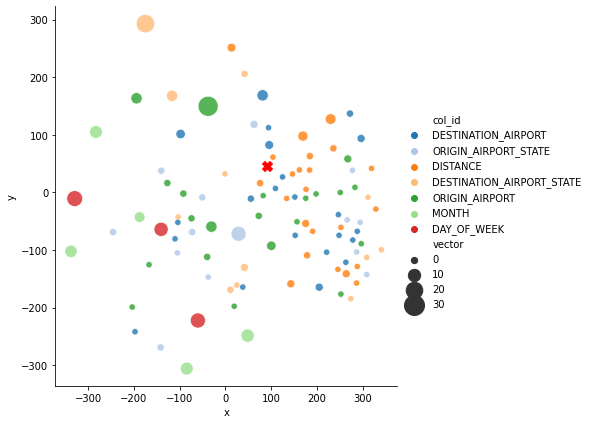

In [120]:
plot_single_table_relative_vectors(table[:,idx],cell_vectors,s_vocab=shuffled_vocab,labels=labels,sample=0.5)

In [96]:
table=tokenized_tables[49]

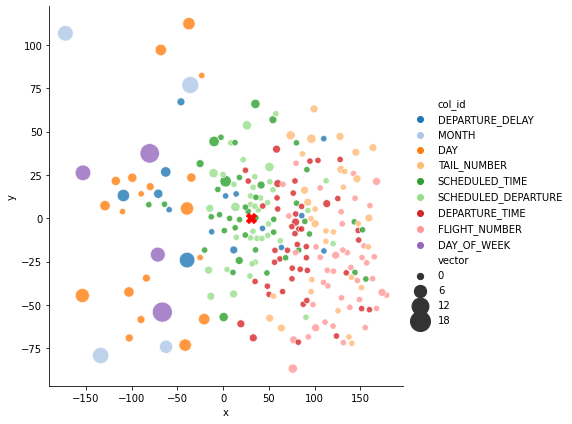

In [97]:

plot_single_table_relative_vectors(table[:,:10],cell_vectors,s_vocab=shuffled_vocab,labels=list(dataset[0]["table"].columns),sample=0.5)